# Generating LPM trajectories showing creation and annihilation
Tim Tyree <br>
3.29.2025

In [1]:
from lib import *
from lib.my_initialization import *
plt.plot([1]*4)
plt.close()
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mpl.rcParams.update(matplotlib.rcParamsDefault) #reset matplotlib

# define module

In [2]:
# @njit
def sqdiff(x1, x2):
    return pow((x1-x2),2)

# @njit
def min3(num1, num2, num3):
    if (num1 > num2 ):
        mn=num2
    else:
        mn=num1
    if (mn>num3):
        mn=num3
    return mn

# @njit
def dist_pbc(x1, y1, x2, y2, L):
    # returns the smallest dist of each possible pbc combination
    xsq1 = sqdiff(x1,x2)
    xsq2 = sqdiff(x1,x2+L)
    xsq3 = sqdiff(x1,x2-L)
    ysq1 = sqdiff(y1,y2)
    ysq2 = sqdiff(y1,y2+L)
    ysq3 = sqdiff(y1,y2-L)
    xsq  = min3(xsq1,xsq2,xsq3)
    ysq  = min3(ysq1,ysq2,ysq3)
    return np.sqrt(xsq+ysq)

# @njit
def subtract_pbc_1d(x1, x2, L):
    # returns the smallest dist of each possible pbc combination
    dx = x1-x2
    dx1 = x1-x2+L
    dx2 = x1-x2-L
    if (abs(dx1)<abs(dx)):
        dx=dx1;
    else:
        if (abs(dx2)<abs(dx)):
            dx=dx2
    return dx

# @njit
def reflection(X, L):
    return L-abs(L-abs(X % 2.*L))
# @njit
def periodic(X, L):
    x=X % L
    if (x<0.):
        return x+L
    return x
# def seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100):
#     """
#     Example Usage:
# xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100)
#     """
#     xg=np.random.uniform(0,1)*L
#     yg=np.random.uniform(0,1)*L
#     mindist=2.*L
#     for j in np.argwhere(still_running).flatten():
#         dist=dist_pbc(xg,yg,x_new[j],y_new[j],L);
#         if dist<mindist:
#             mindist=dist
#     #while new particle is within distance R_c_bar from any other particle
#     num=0
#     while (mindist<R_c_bar) and (num<max_num_retries):
#         num+=1
#         xg=np.random.uniform(0,1)*L
#         yg=np.random.uniform(0,1)*L
#         mindist=2.*L
#         for j in np.argwhere(still_running).flatten():
#             dist=dist_pbc(xg,yg,x_new[j],y_new[j],L);
#             if dist<mindist:
#                 mindist=dist
#     return xg,yg

# dev visualization of spiral tip recombination

In [52]:
#########################################################
# controller
#########################################################
#input minimum lifetime of recombination event
lifetime_trgt = 0.1822200 # s FK
# lifetime_trgt = 0.2394400 # s LR

#compute scale of positions
width = 200
height = 200
L = 5 #cm
ds = L/width
distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)
mesh_shape=np.array((width,height))
ds

#load spiral tip trajectories
fldr = f'{nb_dir}/../../care/notebooks/Data/initial-conditions-suite-1/ds_5_param_set_8/trajectories'
trial_fldr_lst = sorted([x for x in os.listdir(fldr) if x[0]!='.'])
max_num_trials = len(trial_fldr_lst)
print(f"{max_num_trials=}")

max_num_trials=53


trial_index=0; rindex=0


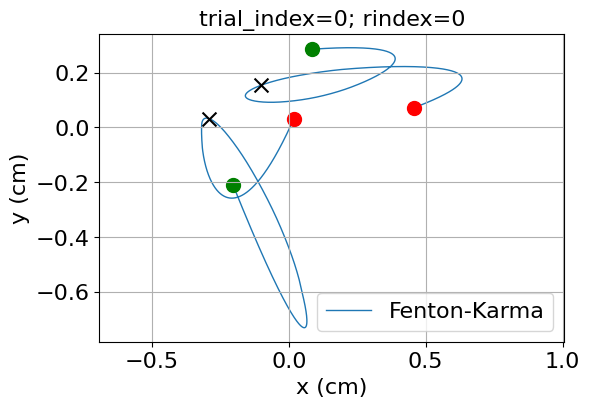

trial_index=2; rindex=1


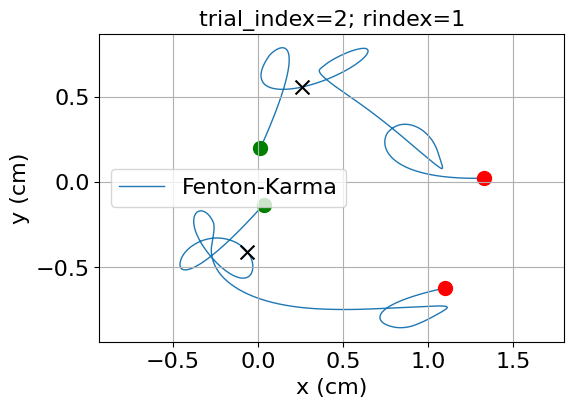

trial_index=2; rindex=2


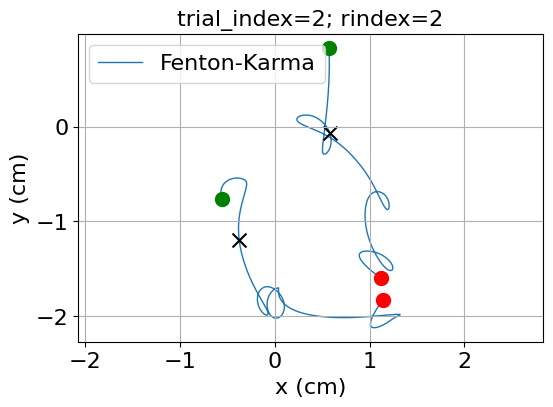

trial_index=6; rindex=0


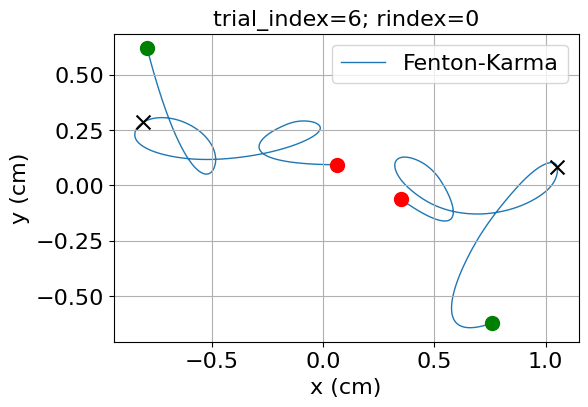

trial_index=10; rindex=0


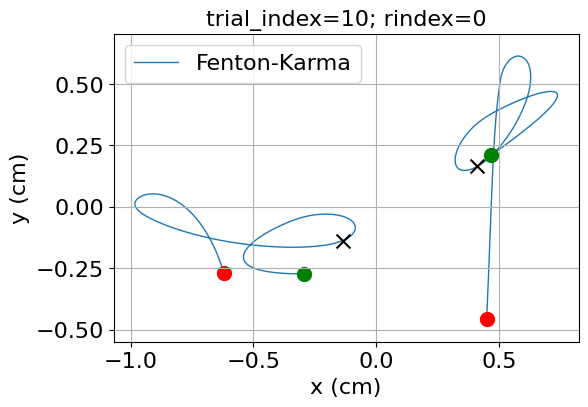

trial_index=14; rindex=0


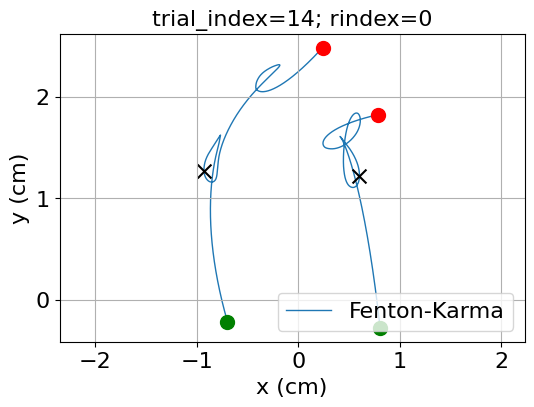

trial_index=15; rindex=0


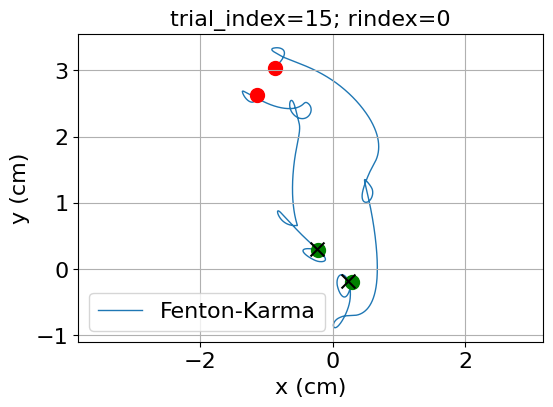

trial_index=20; rindex=0


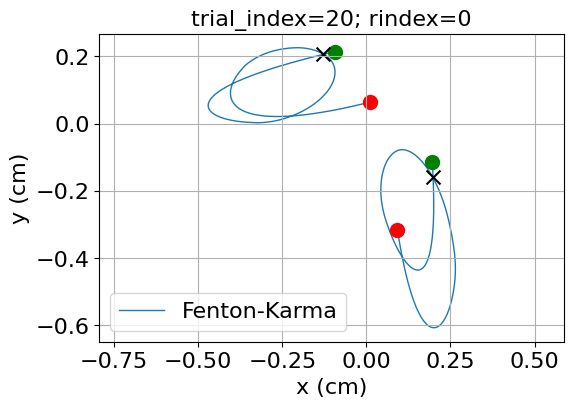

trial_index=20; rindex=1


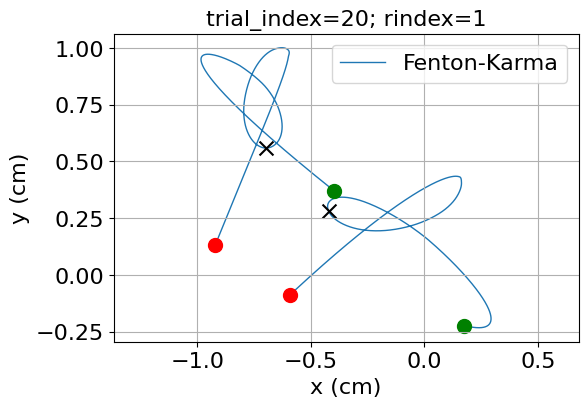

trial_index=22; rindex=0


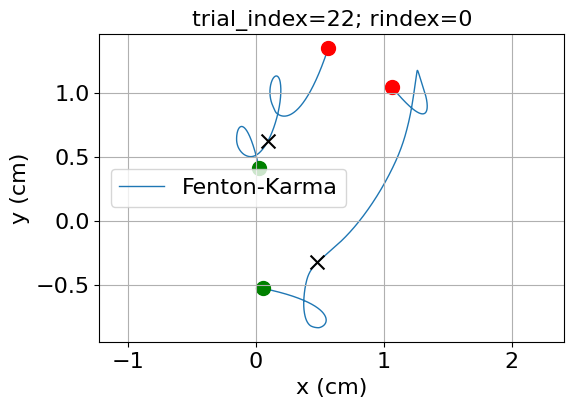

trial_index=22; rindex=1


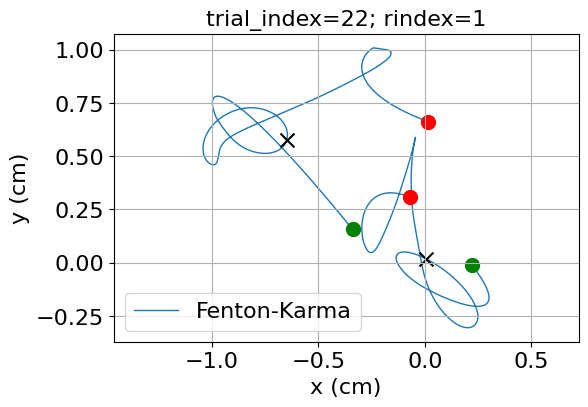

trial_index=23; rindex=0


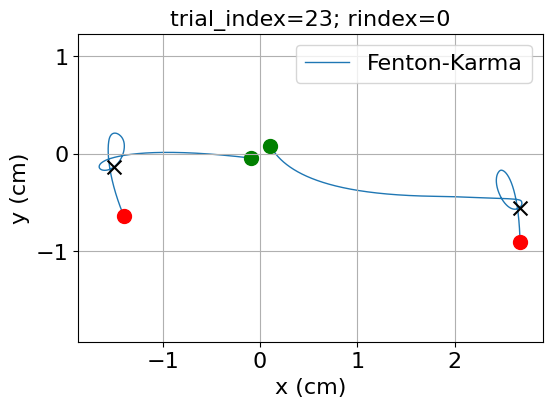

trial_index=24; rindex=0


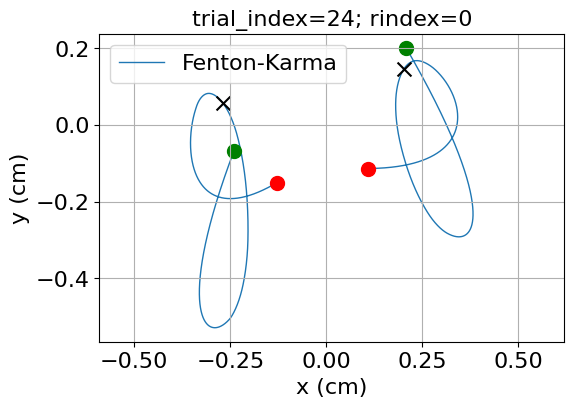

trial_index=37; rindex=0


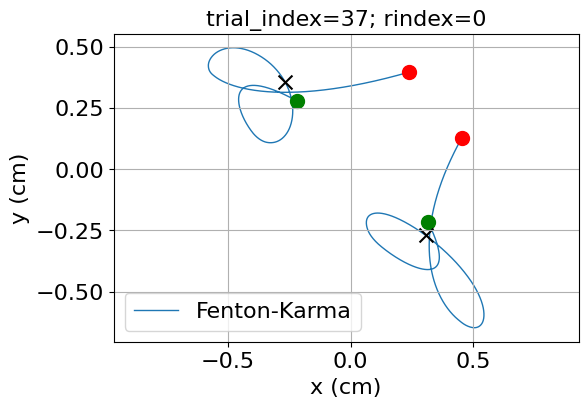

trial_index=37; rindex=1


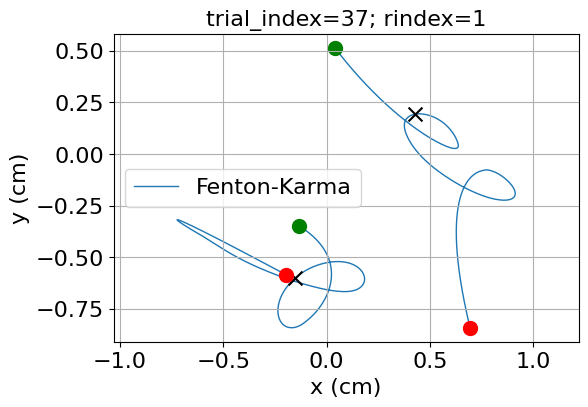

trial_index=41; rindex=0


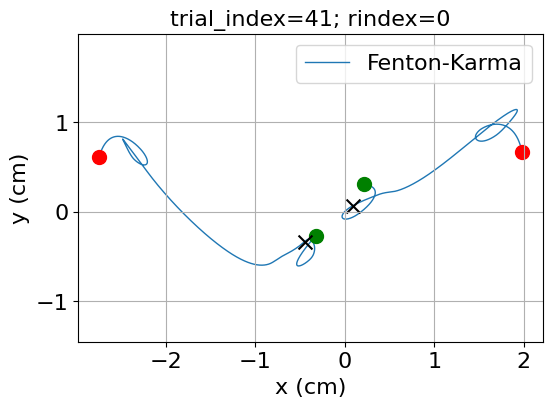

trial_index=45; rindex=0


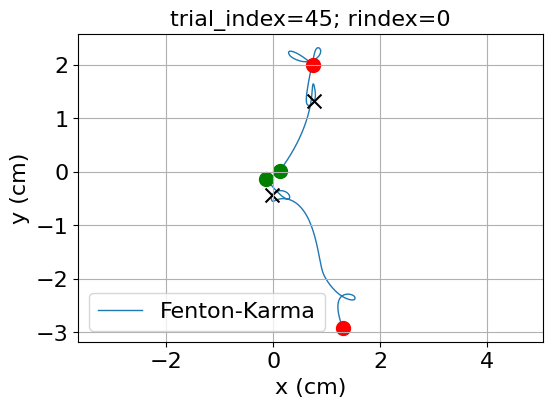

trial_index=46; rindex=0


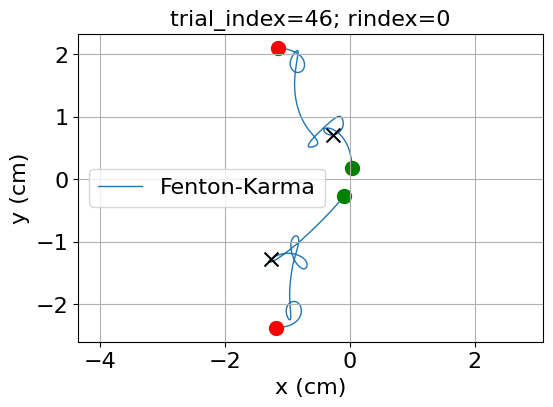

trial_index=47; rindex=0


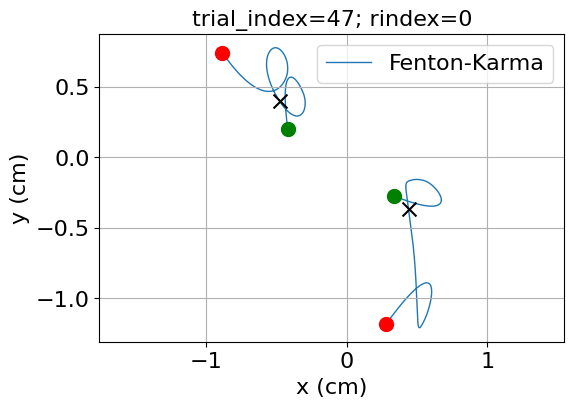

trial_index=47; rindex=1


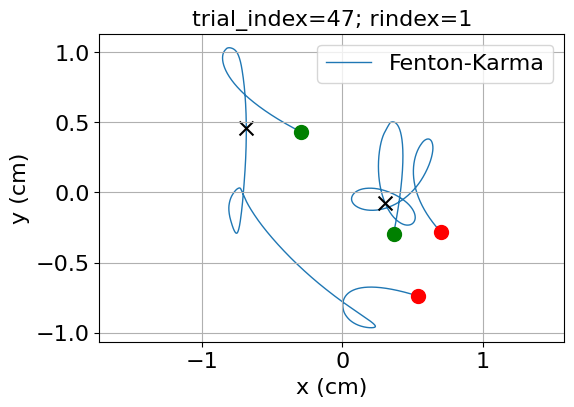

trial_index=47; rindex=2


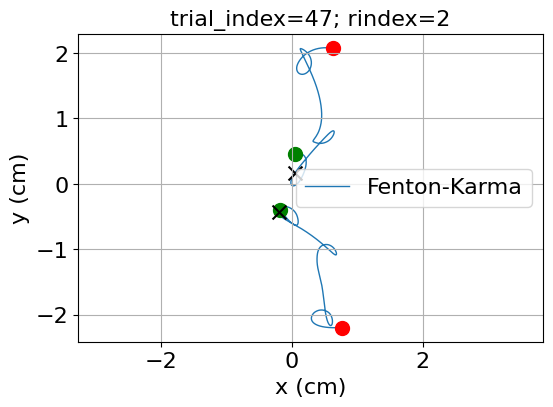

trial_index=52; rindex=0


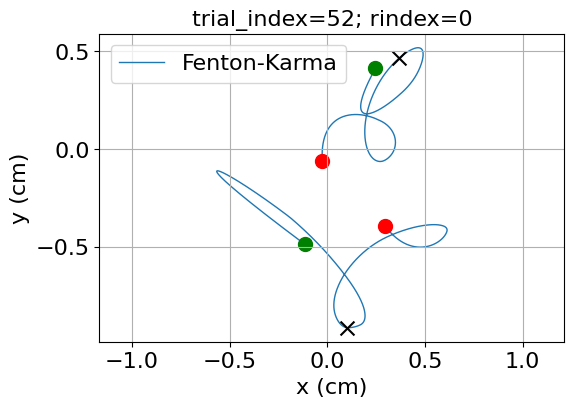

-n 


0

In [53]:
for trial_index in range(0,max_num_trials):
    #########################################################
    # model
    #########################################################
    trajdir = os.path.join(fldr,trial_fldr_lst[trial_index])
    df = pd.read_csv(trajdir)
    df['cid'] = df['particle']
    DT = np.around(df['t'].drop_duplicates().sort_values().diff().dropna().median(),7)/1e3 #s
    num_frames_trgt = np.floor(lifetime_trgt/DT)
    dlifeframes = df.groupby(by='particle')['frame'].count().copy()

    #filter shorter lived tips
    df_tips = pd.DataFrame(dlifeframes[dlifeframes>=num_frames_trgt].sort_values())

    #find creation and annihilation partners for each tip
    cid_set_recombining = set()
    dict_recombining_lst = []
    for cid,row in df_tips.iterrows():
        if not (cid in cid_set_recombining):
            #determine birth/death partners, as before
            cid_birthmate, nearest_dist_birth, t_birth = identify_birth_partner(df,cid,distance_L2_pbc,cid_others=None)
            cid_deathmate, nearest_dist_death, t_death = identify_death_partner(df,cid,distance_L2_pbc,cid_others=None)
            #record any recombination
            if cid_birthmate==cid_deathmate:
                cid_set_recombining.update({cid})
                cid_set_recombining.update({cid_birthmate})
                dict_recombining_lst.append(dict(
                    cid_self = cid,
                    cid_other = cid_birthmate,
                    nearest_dist_birth = nearest_dist_birth*ds, #cm
                    nearest_dist_death = nearest_dist_death*ds, #cm
                    t_birth = t_birth, #ms
                    t_death = t_death, #ms
                    lifetime = (t_death - t_birth)/1e3, #s
                ))
    df_recombining = pd.DataFrame(dict_recombining_lst); del dict_recombining_lst
    num_recombinations = df_recombining.shape[0]
    for rindex in range(num_recombinations):
        #select a recombination event
        row = df_recombining.loc[rindex]

        #get raw trajectories for the selected recombination
        xy_values_self_raw = df[df['cid']==row['cid_self']].sort_values(by='t')[['x','y']].values
        xy_values_other_raw = df[df['cid']==row['cid_other']].sort_values(by='t')[['x','y']].values

        #trajectories share the same shape. consider valid recombination event
        if xy_values_self_raw.shape==xy_values_other_raw.shape:
            #unwrap_xy_values
            xy_values_self_unwrapped = np.stack(unwrap_xy_values(xy_values_self_raw[:,0],xy_values_self_raw[:,1],
                                                    width,height,jump_thresh=None,)).T
            xy_values_other_unwrapped = np.stack(unwrap_xy_values(xy_values_other_raw[:,0],xy_values_other_raw[:,1],
                                                    width,height,jump_thresh=None,)).T
            point1 = xy_values_self_unwrapped[0]
            point2 = xy_values_other_unwrapped[0]
            #undo any relative winding between initial positions
            dw_lst = []
            for q1, q2, wid in zip(point1, point2, mesh_shape):
                iw = np.argmin(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
                dw = np.array([0.,wid,-wid])[iw]
                dw_lst.append(dw)

            #unwind and center about birth
            xy_values_other_unwrapped_unwinding = xy_values_other_unwrapped + np.array(dw_lst)
            xy_center = np.mean((point1,xy_values_other_unwrapped_unwinding[0]),axis=0)

            #center and scale to centimeters
            xy_values_self_full = ds*(xy_values_self_unwrapped - xy_center)
            xy_values_other_full = ds*(xy_values_other_unwrapped_unwinding - xy_center)

            #upsample
            dt = 1e-5
            t_values = np.arange(row['t_birth']/1e3,(row['t_death']+DT)/1e3,DT)
            t_values_interp = np.arange(row['t_birth']/1e3,(row['t_death']+DT)/1e3,dt)
            t_values = t_values[:xy_values_self_full.shape[0]].copy() 
            xy_values_self_full = np.stack((np.interp(t_values_interp,t_values,xy_values_self_full[:,0]),
                                            np.interp(t_values_interp,t_values,xy_values_self_full[:,1]))).T
            xy_values_other_full = np.stack((np.interp(t_values_interp,t_values,xy_values_other_full[:,0]),
                                            np.interp(t_values_interp,t_values,xy_values_other_full[:,1]))).T

            #smooth
            creation_duration = 0.1 #s #both FK and LR
            window_dur = float(creation_duration)# 0.1 #s
            window_length=int(window_dur/dt)
            if window_length%2==0:
                window_length+=1 #must be odd
            xy_values_self_full = savgol_filter(xy_values_self_full.T,
                window_length=window_length,polyorder=3,
                deriv=0,delta=1.0,axis=-1,mode='interp',cval=0.0,).T
            xy_values_other_full = savgol_filter(xy_values_other_full.T,
                window_length=window_length,polyorder=3,
                deriv=0,delta=1.0,axis=-1,mode='interp',cval=0.0,).T

            #########################################################
            # viewer
            #########################################################
            #visualize like in Fig. 1B in the annihilation dynamics paper
            color = 'C0'
            fontsize=16
            lw=1
            title = f"{trial_index=}; {rindex=}"
            print(title)
            fig,ax=plt.subplots(figsize=(6,4))
            #plot birth
            # plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100)
            # plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100)
            plt.scatter([xy_values_self_full[0,0]],[xy_values_self_full[0,1]],color='green',s=100)
            plt.scatter([xy_values_other_full[0,0]],[xy_values_other_full[0,1]],color='green',s=100)
            try:
                #plot repulsion turning off
                ioff = int(creation_duration/dt)
            #     plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x')
            #     plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x')
                plt.scatter([xy_values_self_full[ioff,0]],[xy_values_self_full[ioff,1]],color='k',s=100,marker='x')
                plt.scatter([xy_values_other_full[ioff,0]],[xy_values_other_full[ioff,1]],color='k',s=100,marker='x')
            except IndexError as e:
                pass
            #plot death
            # plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100)
            # plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100)
            plt.scatter([xy_values_self_full[-1,0]],[xy_values_self_full[-1,1]],color='red',s=100)
            plt.scatter([xy_values_other_full[-1,0]],[xy_values_other_full[-1,1]],color='red',s=100)

            #plot trajectories
            # plt.plot(xy_values_self[:,0],xy_values_self[:,1],color='gray',lw=lw,zorder=-1)
            # plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=lw,zorder=-1,label='LPM Fit to\nFenton-Karma')
            plt.plot(xy_values_self_full[:,0],xy_values_self_full[:,1],color=color,lw=lw,zorder=-1)
            plt.plot(xy_values_other_full[:,0],xy_values_other_full[:,1],color=color,lw=lw,zorder=-1,label='Fenton-Karma')
            # format_plot
            format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
            ax = plt.gca()
            ax.grid('on')
            ax.axis('equal')
            ax.legend(fontsize=fontsize)
            ax.set_title(title,fontsize=fontsize)
            plt.show()
beep(1)

In [54]:
# trial_index=6; rindex=0
# trial_index=20; rindex=0 #nice 
# trial_index=24; rindex=0
# trial_index=47; rindex=1
# trial_index=52; rindex=0
# trial_index=37; rindex=0 #nice and symmetric
trial_index=2; rindex=1

trial_index=2; rindex=1


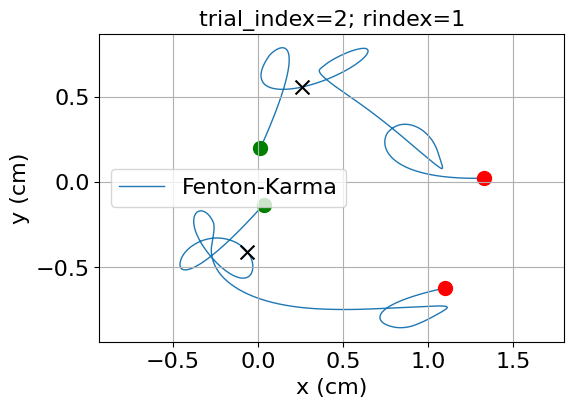

-n 


0

In [55]:
# trial_index = 2 #rindex = 1 not bad, shows immediate outward motion
# # trial_index = 6 #rindex = 0 tad worse
# # trial_index = 10 #rindex = 0 tad worse
# # trial_index = 15 #rindex = 0 drifty
# trial_index = 20
# for trial_index in range(0,max_num_trials):
if True:
    #########################################################
    # model
    #########################################################
    trajdir = os.path.join(fldr,trial_fldr_lst[trial_index])
    df = pd.read_csv(trajdir)
    df['cid'] = df['particle']
    DT = np.around(df['t'].drop_duplicates().sort_values().diff().dropna().median(),7)/1e3 #s
    num_frames_trgt = np.floor(lifetime_trgt/DT)
    dlifeframes = df.groupby(by='particle')['frame'].count().copy()

    #filter shorter lived tips
    df_tips = pd.DataFrame(dlifeframes[dlifeframes>=num_frames_trgt].sort_values())

    #find creation and annihilation partners for each tip
    cid_set_recombining = set()
    dict_recombining_lst = []
    for cid,row in df_tips.iterrows():
        if not (cid in cid_set_recombining):
            #determine birth/death partners, as before
            cid_birthmate, nearest_dist_birth, t_birth = identify_birth_partner(df,cid,distance_L2_pbc,cid_others=None)
            cid_deathmate, nearest_dist_death, t_death = identify_death_partner(df,cid,distance_L2_pbc,cid_others=None)
            #record any recombination
            if cid_birthmate==cid_deathmate:
                cid_set_recombining.update({cid})
                cid_set_recombining.update({cid_birthmate})
                dict_recombining_lst.append(dict(
                    cid_self = cid,
                    cid_other = cid_birthmate,
                    nearest_dist_birth = nearest_dist_birth*ds, #cm
                    nearest_dist_death = nearest_dist_death*ds, #cm
                    t_birth = t_birth, #ms
                    t_death = t_death, #ms
                    lifetime = (t_death - t_birth)/1e3, #s
                ))
    df_recombining = pd.DataFrame(dict_recombining_lst); del dict_recombining_lst
    num_recombinations = df_recombining.shape[0]
#     for rindex in range(num_recombinations):
    if True:
        #select a recombination event
        row = df_recombining.loc[rindex]

        #get raw trajectories for the selected recombination
        xy_values_self_raw = df[df['cid']==row['cid_self']].sort_values(by='t')[['x','y']].values
        xy_values_other_raw = df[df['cid']==row['cid_other']].sort_values(by='t')[['x','y']].values

        #trajectories share the same shape. consider valid recombination event
        if xy_values_self_raw.shape==xy_values_other_raw.shape:
            #unwrap_xy_values
            xy_values_self_unwrapped = np.stack(unwrap_xy_values(xy_values_self_raw[:,0],xy_values_self_raw[:,1],
                                                    width,height,jump_thresh=None,)).T
            xy_values_other_unwrapped = np.stack(unwrap_xy_values(xy_values_other_raw[:,0],xy_values_other_raw[:,1],
                                                    width,height,jump_thresh=None,)).T
            point1 = xy_values_self_unwrapped[0]
            point2 = xy_values_other_unwrapped[0]
            #undo any relative winding between initial positions
            dw_lst = []
            for q1, q2, wid in zip(point1, point2, mesh_shape):
                iw = np.argmin(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
                dw = np.array([0.,wid,-wid])[iw]
                dw_lst.append(dw)

            #unwind and center about birth
            xy_values_other_unwrapped_unwinding = xy_values_other_unwrapped + np.array(dw_lst)
            xy_center = np.mean((point1,xy_values_other_unwrapped_unwinding[0]),axis=0)

            #center and scale to centimeters
            xy_values_self_full = ds*(xy_values_self_unwrapped - xy_center)
            xy_values_other_full = ds*(xy_values_other_unwrapped_unwinding - xy_center)

            #upsample
            dt = 1e-5
            t_values = np.arange(row['t_birth']/1e3,(row['t_death']+DT)/1e3,DT)
            t_values_interp = np.arange(row['t_birth']/1e3,(row['t_death']+DT)/1e3,dt)
            t_values = t_values[:xy_values_self_full.shape[0]].copy() 
            xy_values_self_full = np.stack((np.interp(t_values_interp,t_values,xy_values_self_full[:,0]),
                                            np.interp(t_values_interp,t_values,xy_values_self_full[:,1]))).T
            xy_values_other_full = np.stack((np.interp(t_values_interp,t_values,xy_values_other_full[:,0]),
                                            np.interp(t_values_interp,t_values,xy_values_other_full[:,1]))).T

            #smooth
            creation_duration = 0.1 #s #both FK and LR
            window_dur = float(creation_duration)# 0.1 #s
            window_length=int(window_dur/dt)
            if window_length%2==0:
                window_length+=1 #must be odd
            xy_values_self_full = savgol_filter(xy_values_self_full.T,
                window_length=window_length,polyorder=3,
                deriv=0,delta=1.0,axis=-1,mode='interp',cval=0.0,).T
            xy_values_other_full = savgol_filter(xy_values_other_full.T,
                window_length=window_length,polyorder=3,
                deriv=0,delta=1.0,axis=-1,mode='interp',cval=0.0,).T

            #########################################################
            # viewer
            #########################################################
            #visualize like in Fig. 1B in the annihilation dynamics paper
            color = 'C0'
            fontsize=16
            lw=1
            title = f"{trial_index=}; {rindex=}"
            print(title)
            fig,ax=plt.subplots(figsize=(6,4))
            #plot birth
            # plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100)
            # plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100)
            plt.scatter([xy_values_self_full[0,0]],[xy_values_self_full[0,1]],color='green',s=100)
            plt.scatter([xy_values_other_full[0,0]],[xy_values_other_full[0,1]],color='green',s=100)
            try:
                #plot repulsion turning off
                ioff = int(creation_duration/dt)
            #     plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x')
            #     plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x')
                plt.scatter([xy_values_self_full[ioff,0]],[xy_values_self_full[ioff,1]],color='k',s=100,marker='x')
                plt.scatter([xy_values_other_full[ioff,0]],[xy_values_other_full[ioff,1]],color='k',s=100,marker='x')
            except IndexError as e:
                pass
            #plot death
            # plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100)
            # plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100)
            plt.scatter([xy_values_self_full[-1,0]],[xy_values_self_full[-1,1]],color='red',s=100)
            plt.scatter([xy_values_other_full[-1,0]],[xy_values_other_full[-1,1]],color='red',s=100)

            #plot trajectories
            # plt.plot(xy_values_self[:,0],xy_values_self[:,1],color='gray',lw=lw,zorder=-1)
            # plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=lw,zorder=-1,label='LPM Fit to\nFenton-Karma')
            plt.plot(xy_values_self_full[:,0],xy_values_self_full[:,1],color=color,lw=lw,zorder=-1)
            plt.plot(xy_values_other_full[:,0],xy_values_other_full[:,1],color=color,lw=lw,zorder=-1,label='Fenton-Karma')
            # format_plot
            format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
            ax = plt.gca()
            ax.grid('on')
            ax.axis('equal')
            ax.legend(fontsize=fontsize)
            ax.set_title(title,fontsize=fontsize)
            plt.show()
beep(1)

In [56]:
#DONE: visualize like in Fig. 1B in the annihilation dynamics paper

# dev visualization of LPM motion with creation fit to FK model

            FK LR
    D (cm2/s) 0.115 ± 0.008 0.42 ± 0.14
    a (cm2/s) 1.552 ± 0.017 9.3 ±0.3
    r (cm) 0.457±0.009 0.314±0.003
    κ (Hz) 15 75

          FK LR
    δ (s) 0.1 0.1
    r0 (cm) 0.131 ± 0.001 0.202 ± 0.003
    b (cm2/s) 3.01±0.05 10.0 ± 0.5
    Rc (cm) 0.85 1.25

In [57]:
#recall LPM movement parameters for the FK model
D = 0.115 #cm^2/s FK
# D = 0.42 #cm^2/s LR
a = 1.552 #cm^2/s FK
# a = 9.3 #cm^2/s LR
r = 0.457 #cm FK
# r = 0.314 #cm LR
kappa = 15 #Hz FK
# kappa = 75 #Hz LR

#recall LPM creation parameters for the FK model
Rc = 0.85 # cm FK
# Rc = 1.25 # cm LR
# creation_duration = 0.1 #s #both FK and LR
b = 3.01 #±0.05 cm^2/s FK
# b = 10.0 #±0.5 cm^2/s LR
r0 = 1.31 #±0.001 cm FK
# r0 = 0.202 #±0.003 cm LR

In [58]:
#place 2 particles at a given initial angle (theta0=-pi/4) centered about the origin
theta0=-np.pi/4
rc = Rc/2.
xy0_self = rc*np.array([np.cos(theta0),np.sin(theta0)])
xy0_other = rc*np.array([np.cos(theta0+np.pi),np.sin(theta0+np.pi)])

In [59]:
dt = 1e-5
# seed = 42
# seed = 5 #beautiful++
# # seed = 8 #beautiful+
# # seed = 12 #gorgeous
seed=13 #beautiful++
#heretim
# tmax = 30. #seconds
tmax = 3. #seconds
# tmax = .3 #seconds
printing=True
np.random.seed(seed)
rsq = r**2
t = 0
xy_lst_self = [xy0_self]
xy_lst_other = [xy0_other]
#time evolve their trajectories with no other creations/particles
nsteps = int(tmax/dt)
step = 0
while t<tmax:
    step +=1
    t+=dt
    #recall positions
    xy_self = xy_lst_self[-1]
    xy_other = xy_lst_other[-1]
    Rsq = np.sum((xy_self - xy_other) ** 2)
    x_self_next = xy_self[0]
    x_other_next = xy_other[0]
    y_self_next = xy_self[1]
    y_other_next = xy_other[1]
    dx = (x_other_next - x_self_next).copy()
    dy = (y_other_next - y_self_next).copy()
#     #apply repulsive force
#     if t<creation_duration:
#         x_self_next+=dt*b*dx/Rsq
#         x_other_next-=dt*b*dx/Rsq
#         y_self_next+=dt*b*dy/Rsq
#         y_other_next-=dt*b*dy/Rsq
    #apply repulsive force
    if t<creation_duration:
        x_self_next-=dt*b*dx/Rsq
        x_other_next+=dt*b*dx/Rsq
        y_self_next-=dt*b*dy/Rsq
        y_other_next+=dt*b*dy/Rsq
#     #apply attractive force
#     x_self_next-=dt*a*dx/Rsq
#     x_other_next+=dt*a*dx/Rsq
#     y_self_next-=dt*a*dy/Rsq
#     y_other_next+=dt*a*dy/Rsq
    #apply attractive force
    x_self_next+=dt*a*dx/Rsq
    x_other_next-=dt*a*dx/Rsq
    y_self_next+=dt*a*dy/Rsq
    y_other_next-=dt*a*dy/Rsq
    #apply noise
    Dcoeff = np.sqrt(2.*D*dt)
    x_self_next += Dcoeff*np.random.normal()
    x_other_next+= Dcoeff*np.random.normal()
    y_self_next+=  Dcoeff*np.random.normal()
    y_other_next+= Dcoeff*np.random.normal()
    #record
    xy_self = np.array([x_self_next,y_self_next])
    xy_other = np.array([x_other_next,y_other_next])
    xy_lst_self.append(xy_self)
    xy_lst_other.append(xy_other)
    if printing and (step % 1000 == 0):
        printProgressBar(step,nsteps)    
    #implement capture stop condition
    if Rsq<rsq:
        p = np.random.rand()
        if p<kappa*dt:
            tmax = t
print(f"\n{tmax=}")

 |██████----------------------------------------------------------------------------------------------| 6.0% 
tmax=0.18222000000004146


In [60]:
xy_values_self = np.stack(xy_lst_self)
xy_values_other = np.stack(xy_lst_other)

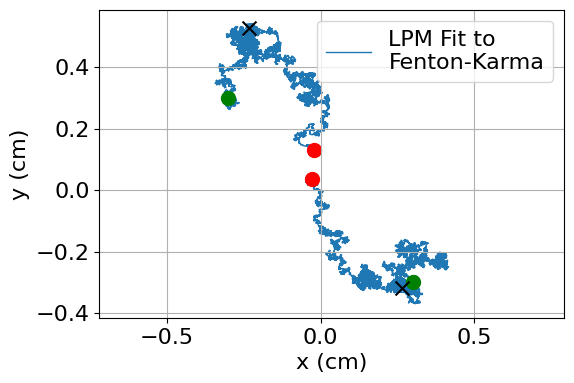

In [61]:
#TODO: visualize like in Fig. 1B in the annihilation dynamics paper
color = 'C0'
fontsize=16
lw=1
fig,ax=plt.subplots(figsize=(6,4))
#plot birth
plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100)
plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100)
try:
    #plot repulsion turning off
    ioff = int(creation_duration/dt)
    plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x')
    plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x')
except IndexError as e:
    pass
#plot death
plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100)
plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100)


plt.plot(xy_values_self[:,0],xy_values_self[:,1],color=color,lw=lw,zorder=-1)
plt.plot(xy_values_other[:,0],xy_values_other[:,1],color=color,lw=lw,zorder=-1,label='LPM Fit to\nFenton-Karma')
# plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=2)

format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
ax = plt.gca()
ax.grid('on')
ax.axis('equal')
ax.legend(fontsize=fontsize)
plt.show()

trial_index=2; rindex=1


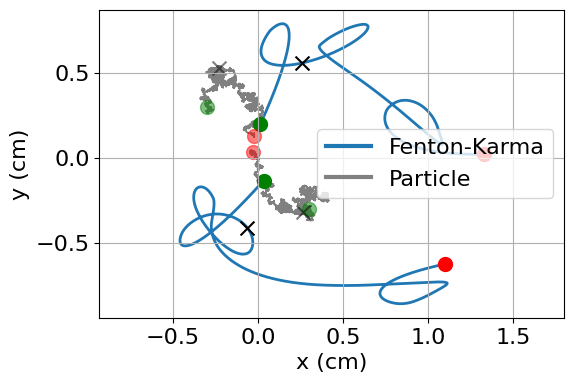

In [62]:
#########################################################
# viewer
#########################################################
#visualize like in Fig. 1B in the annihilation dynamics paper
color = 'C0'
fontsize=16
lw=1
alpha=0.5
title = f"{trial_index=}; {rindex=}"
print(title)
fig,ax=plt.subplots(figsize=(6,4))
#plot birth
plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100,alpha=alpha)
plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100,alpha=alpha)
plt.scatter([xy_values_self_full[0,0]],[xy_values_self_full[0,1]],color='green',s=100)
plt.scatter([xy_values_other_full[0,0]],[xy_values_other_full[0,1]],color='green',s=100)
try:
    #plot repulsion turning off
    ioff = int(creation_duration/dt)
    plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x',alpha=alpha)
    plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x',alpha=alpha)
    plt.scatter([xy_values_self_full[ioff,0]],[xy_values_self_full[ioff,1]],color='k',s=100,marker='x')
    plt.scatter([xy_values_other_full[ioff,0]],[xy_values_other_full[ioff,1]],color='k',s=100,marker='x')
except IndexError as e:
    pass
#plot death
plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100,alpha=alpha)
plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100,alpha=alpha)
plt.scatter([xy_values_self_full[-1,0]],[xy_values_self_full[-1,1]],color='red',s=100)
plt.scatter([xy_values_other_full[-1,0]],[xy_values_other_full[-1,1]],color='red',s=100)

#plot trajectories
plt.plot(xy_values_self_full[:,0],xy_values_self_full[:,1],color=color,lw=lw+1,zorder=-1)
plt.plot(xy_values_other_full[:,0],xy_values_other_full[:,1],color=color,lw=lw+1,zorder=-1,label='Fenton-Karma')
plt.plot(xy_values_self[:,0],xy_values_self[:,1],color='gray',lw=lw,zorder=-1)
plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=lw,zorder=-1,label='Particle')
# format_plot
format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
ax = plt.gca()
ax.grid('on')
ax.axis('equal')
legend = ax.legend(fontsize=fontsize)
#increase the line width in the legend
for line in legend.get_lines():
    line.set_linewidth(3)
# ax.set_title(title,fontsize=fontsize)
plt.show()

trial_index=2; rindex=1


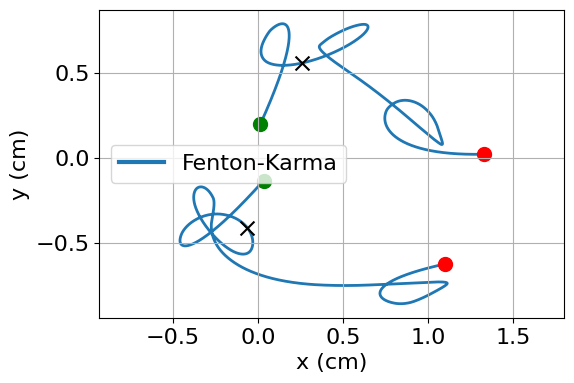

In [63]:
#########################################################
# viewer
#########################################################
#visualize like in Fig. 1B in the annihilation dynamics paper
color = 'C0'
fontsize=16
lw=1
alpha=0.5
title = f"{trial_index=}; {rindex=}"
print(title)
fig,ax=plt.subplots(figsize=(6,4))
#plot birth
# plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100,alpha=alpha)
# plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100,alpha=alpha)
plt.scatter([xy_values_self_full[0,0]],[xy_values_self_full[0,1]],color='green',s=100)
plt.scatter([xy_values_other_full[0,0]],[xy_values_other_full[0,1]],color='green',s=100)
try:
    #plot repulsion turning off
    ioff = int(creation_duration/dt)
#     plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x',alpha=alpha)
#     plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x',alpha=alpha)
    plt.scatter([xy_values_self_full[ioff,0]],[xy_values_self_full[ioff,1]],color='k',s=100,marker='x')
    plt.scatter([xy_values_other_full[ioff,0]],[xy_values_other_full[ioff,1]],color='k',s=100,marker='x')
except IndexError as e:
    pass
#plot death
# plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100,alpha=alpha)
# plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100,alpha=alpha)
plt.scatter([xy_values_self_full[-1,0]],[xy_values_self_full[-1,1]],color='red',s=100)
plt.scatter([xy_values_other_full[-1,0]],[xy_values_other_full[-1,1]],color='red',s=100)

#plot trajectories
plt.plot(xy_values_self_full[:,0],xy_values_self_full[:,1],color=color,lw=lw+1,zorder=-1)
plt.plot(xy_values_other_full[:,0],xy_values_other_full[:,1],color=color,lw=lw+1,zorder=-1,label='Fenton-Karma')
# plt.plot(xy_values_self[:,0],xy_values_self[:,1],color='gray',lw=lw,zorder=-1)
# plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=lw,zorder=-1,label='Particle')
# format_plot
format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
ax = plt.gca()
ax.grid('on')
ax.axis('equal')
legend = ax.legend(fontsize=fontsize)
#increase the line width in the legend
for line in legend.get_lines():
    line.set_linewidth(3)
# ax.set_title(title,fontsize=fontsize)
plt.show()

# repeat for LR model in a separate panel

## find LR model exemplar

In [39]:
#########################################################
# controller
#########################################################
#input minimum lifetime of recombination event
# lifetime_trgt = 0.1822200 # s FK
lifetime_trgt = 0.2394400 # s LR

#compute scale of positions
width = 200
height = 200
L = 5 #cm
ds = L/width
distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)
mesh_shape=np.array((width,height))
ds

#load spiral tip trajectories
# fldr = f'{nb_dir}/../../care/notebooks/Data/initial-conditions-suite-1/ds_5_param_set_8/trajectories'
fldr = f'{nb_dir}/../../care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_3.8_diffCoef_0.001/trajectories'
trial_fldr_lst = sorted([x for x in os.listdir(fldr) if x[0]!='.'])
max_num_trials = len(trial_fldr_lst)
print(f"{max_num_trials=}")

max_num_trials=157


trial_index=3; rindex=0


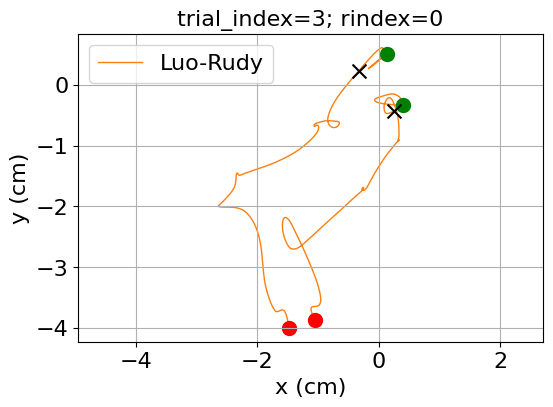

trial_index=12; rindex=0


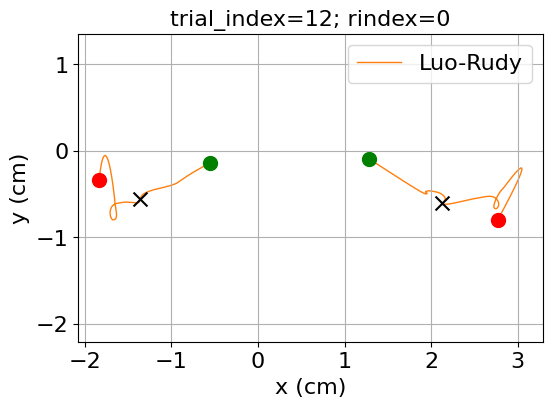

trial_index=14; rindex=0


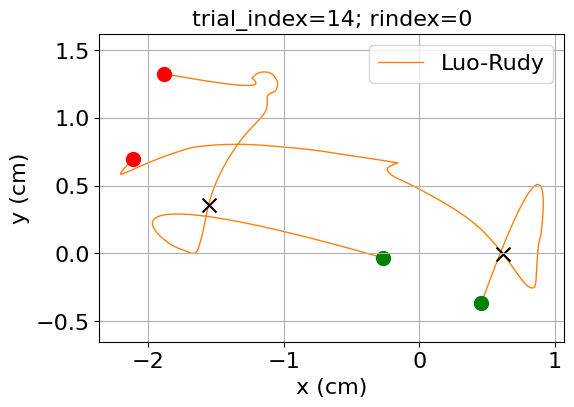

trial_index=23; rindex=0


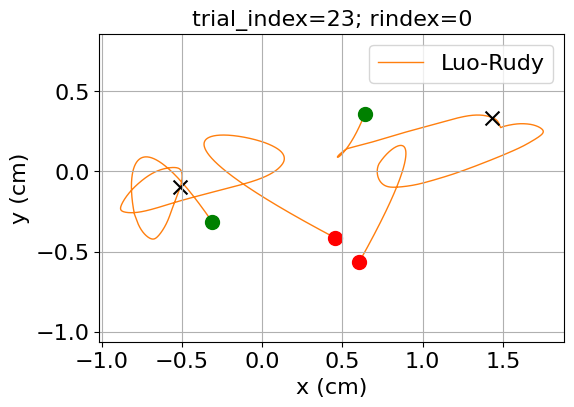

trial_index=25; rindex=0


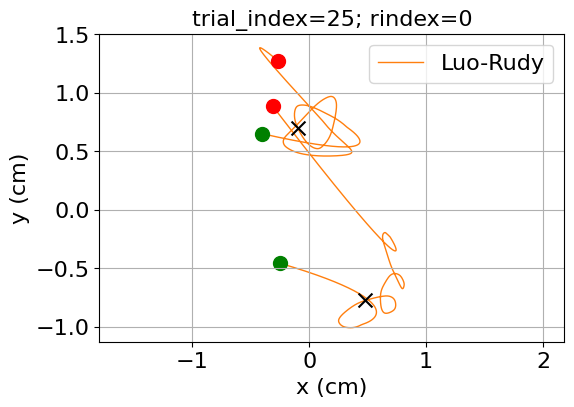

trial_index=33; rindex=0


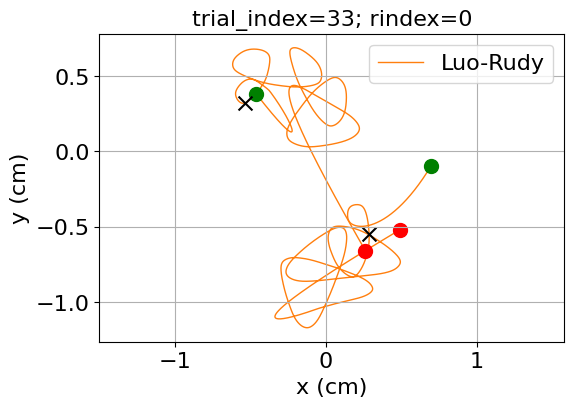

trial_index=34; rindex=0


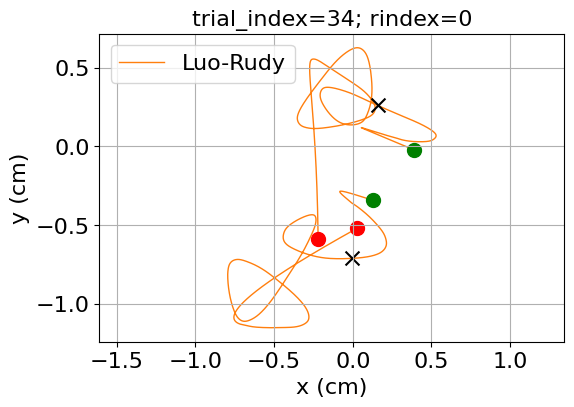

trial_index=40; rindex=0


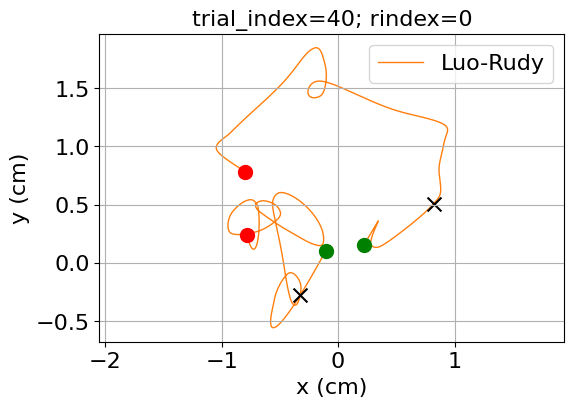

trial_index=41; rindex=0


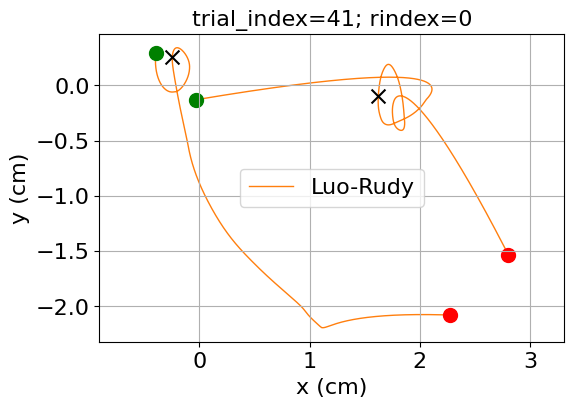

trial_index=51; rindex=0


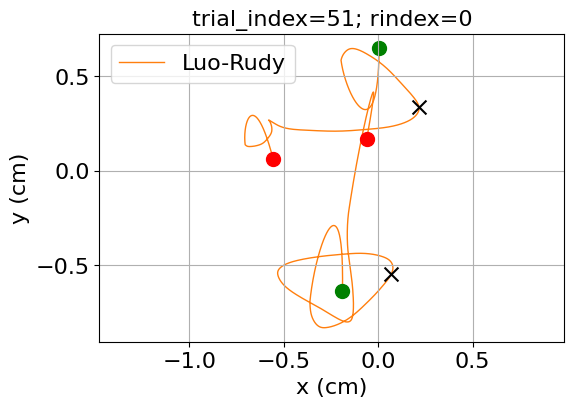

trial_index=62; rindex=0


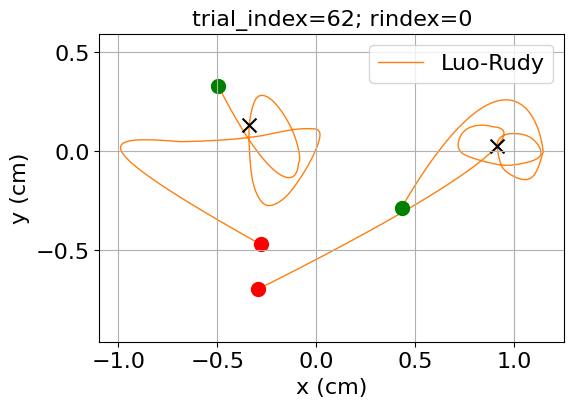

trial_index=64; rindex=0


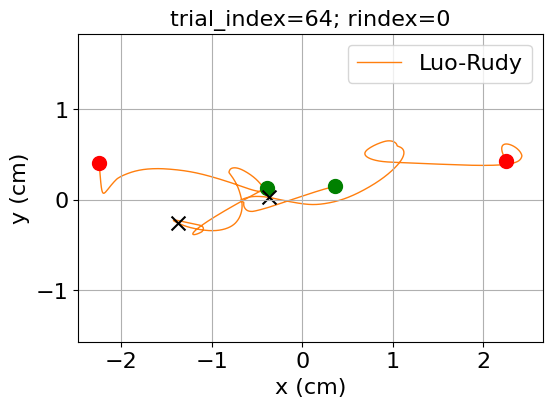

trial_index=72; rindex=0


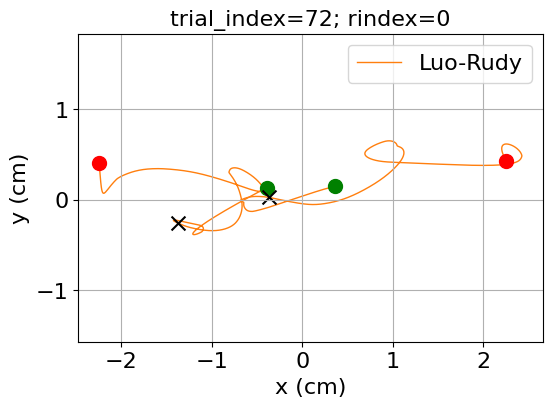

trial_index=93; rindex=0


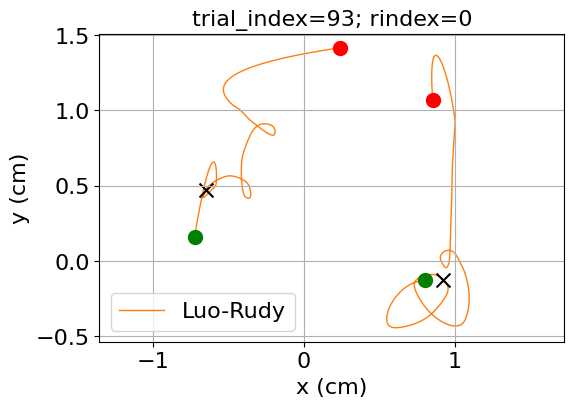

trial_index=99; rindex=0


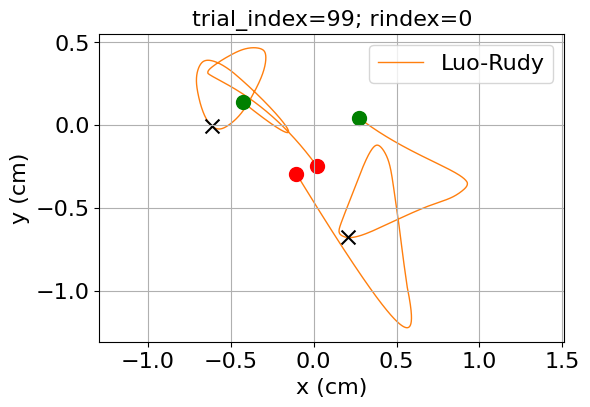

trial_index=103; rindex=0


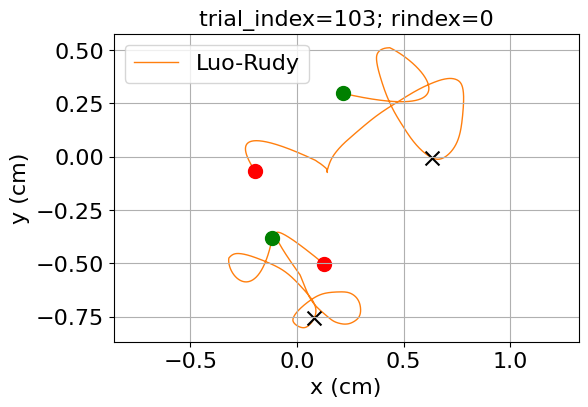

trial_index=113; rindex=0


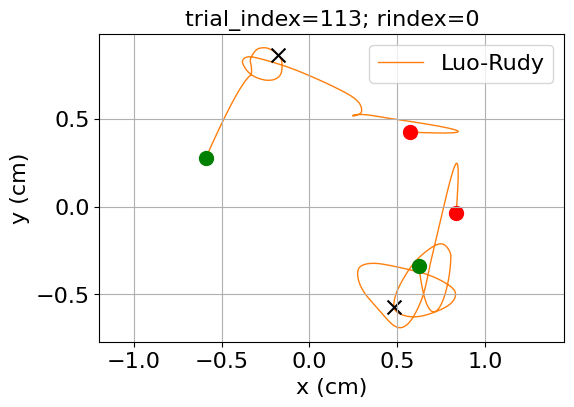

trial_index=120; rindex=0


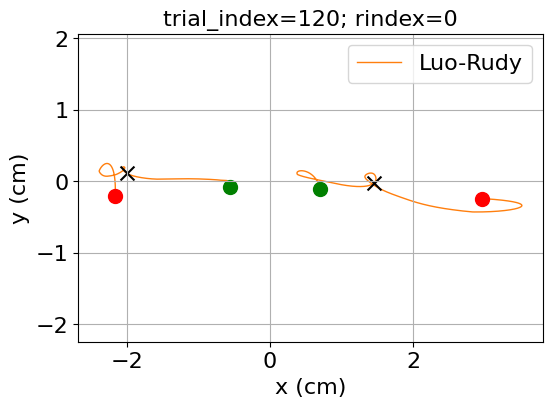

trial_index=126; rindex=0


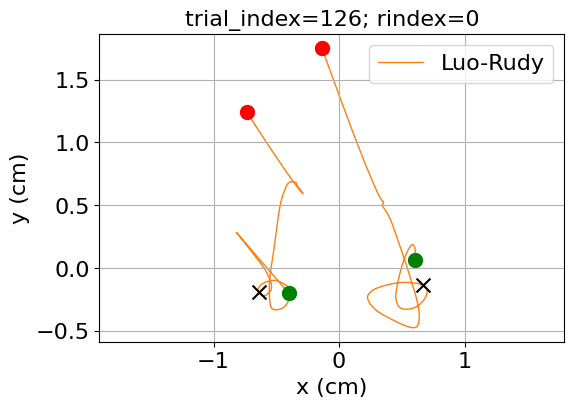

trial_index=129; rindex=0


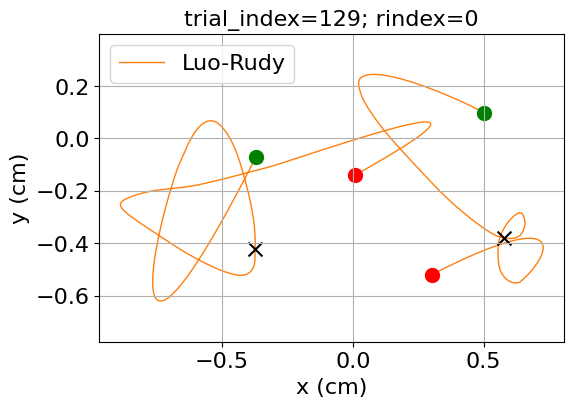

trial_index=138; rindex=0


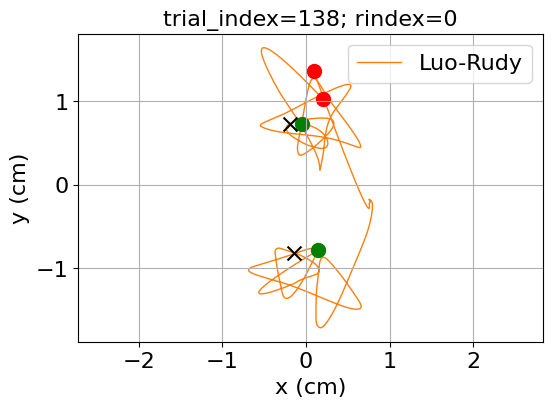

trial_index=143; rindex=0


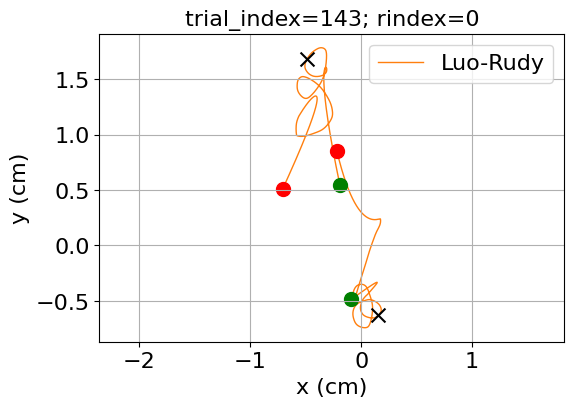

trial_index=145; rindex=0


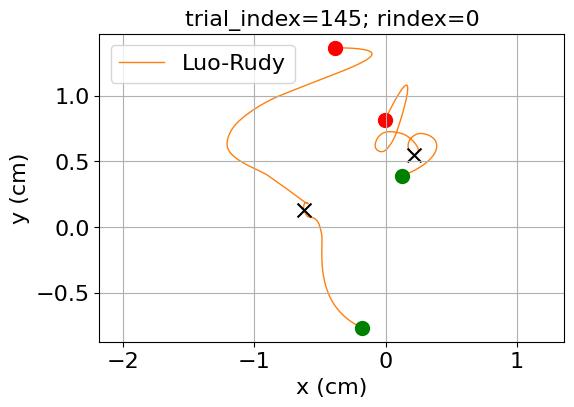

-n 


0

In [40]:
#########################################
for trial_index in range(0,max_num_trials):
    #########################################################
    # model
    #########################################################
    trajdir = os.path.join(fldr,trial_fldr_lst[trial_index])
    df = pd.read_csv(trajdir)
    df['cid'] = df['particle']
    DT = np.around(df['t'].drop_duplicates().sort_values().diff().dropna().median(),7)/1e3 #s
    num_frames_trgt = np.floor(lifetime_trgt/DT)
    dlifeframes = df.groupby(by='particle')['frame'].count().copy()

    #filter shorter lived tips
    df_tips = pd.DataFrame(dlifeframes[dlifeframes>=num_frames_trgt].sort_values())

    #find creation and annihilation partners for each tip
    cid_set_recombining = set()
    dict_recombining_lst = []
    for cid,row in df_tips.iterrows():
        if not (cid in cid_set_recombining):
            #determine birth/death partners, as before
            cid_birthmate, nearest_dist_birth, t_birth = identify_birth_partner(df,cid,distance_L2_pbc,cid_others=None)
            cid_deathmate, nearest_dist_death, t_death = identify_death_partner(df,cid,distance_L2_pbc,cid_others=None)
            #record any recombination
            if cid_birthmate==cid_deathmate:
                cid_set_recombining.update({cid})
                cid_set_recombining.update({cid_birthmate})
                dict_recombining_lst.append(dict(
                    cid_self = cid,
                    cid_other = cid_birthmate,
                    nearest_dist_birth = nearest_dist_birth*ds, #cm
                    nearest_dist_death = nearest_dist_death*ds, #cm
                    t_birth = t_birth, #ms
                    t_death = t_death, #ms
                    lifetime = (t_death - t_birth)/1e3, #s
                ))
    df_recombining = pd.DataFrame(dict_recombining_lst); del dict_recombining_lst
    num_recombinations = df_recombining.shape[0]
    for rindex in range(num_recombinations):
        #select a recombination event
        row = df_recombining.loc[rindex]

        #get raw trajectories for the selected recombination
        xy_values_self_raw = df[df['cid']==row['cid_self']].sort_values(by='t')[['x','y']].values
        xy_values_other_raw = df[df['cid']==row['cid_other']].sort_values(by='t')[['x','y']].values

        #trajectories share the same shape. consider valid recombination event
        if xy_values_self_raw.shape==xy_values_other_raw.shape:
            #unwrap_xy_values
            xy_values_self_unwrapped = np.stack(unwrap_xy_values(xy_values_self_raw[:,0],xy_values_self_raw[:,1],
                                                    width,height,jump_thresh=None,)).T
            xy_values_other_unwrapped = np.stack(unwrap_xy_values(xy_values_other_raw[:,0],xy_values_other_raw[:,1],
                                                    width,height,jump_thresh=None,)).T
            point1 = xy_values_self_unwrapped[0]
            point2 = xy_values_other_unwrapped[0]
            #undo any relative winding between initial positions
            dw_lst = []
            for q1, q2, wid in zip(point1, point2, mesh_shape):
                iw = np.argmin(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
                dw = np.array([0.,wid,-wid])[iw]
                dw_lst.append(dw)

            #unwind and center about birth
            xy_values_other_unwrapped_unwinding = xy_values_other_unwrapped + np.array(dw_lst)
            xy_center = np.mean((point1,xy_values_other_unwrapped_unwinding[0]),axis=0)

            #center and scale to centimeters
            xy_values_self_full = ds*(xy_values_self_unwrapped - xy_center)
            xy_values_other_full = ds*(xy_values_other_unwrapped_unwinding - xy_center)

            #upsample
            dt = 1e-5
            t_values = np.arange(row['t_birth']/1e3,(row['t_death']+DT)/1e3,DT)
            t_values_interp = np.arange(row['t_birth']/1e3,(row['t_death']+DT)/1e3,dt)
            t_values = t_values[:xy_values_self_full.shape[0]].copy() 
            xy_values_self_full = np.stack((np.interp(t_values_interp,t_values,xy_values_self_full[:,0]),
                                            np.interp(t_values_interp,t_values,xy_values_self_full[:,1]))).T
            xy_values_other_full = np.stack((np.interp(t_values_interp,t_values,xy_values_other_full[:,0]),
                                            np.interp(t_values_interp,t_values,xy_values_other_full[:,1]))).T

            #smooth
            creation_duration = 0.1 #s #both FK and LR
            window_dur = float(creation_duration)# 0.1 #s
            window_length=int(window_dur/dt)
            if window_length%2==0:
                window_length+=1 #must be odd
            xy_values_self_full = savgol_filter(xy_values_self_full.T,
                window_length=window_length,polyorder=3,
                deriv=0,delta=1.0,axis=-1,mode='interp',cval=0.0,).T
            xy_values_other_full = savgol_filter(xy_values_other_full.T,
                window_length=window_length,polyorder=3,
                deriv=0,delta=1.0,axis=-1,mode='interp',cval=0.0,).T

            #########################################################
            # viewer
            #########################################################
            #visualize like in Fig. 1B in the annihilation dynamics paper
            color = 'C1'
            fontsize=16
            lw=1
            title = f"{trial_index=}; {rindex=}"
            print(title)
            fig,ax=plt.subplots(figsize=(6,4))
            #plot birth
            # plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100)
            # plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100)
            plt.scatter([xy_values_self_full[0,0]],[xy_values_self_full[0,1]],color='green',s=100)
            plt.scatter([xy_values_other_full[0,0]],[xy_values_other_full[0,1]],color='green',s=100)
            try:
                #plot repulsion turning off
                ioff = int(creation_duration/dt)
            #     plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x')
            #     plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x')
                plt.scatter([xy_values_self_full[ioff,0]],[xy_values_self_full[ioff,1]],color='k',s=100,marker='x')
                plt.scatter([xy_values_other_full[ioff,0]],[xy_values_other_full[ioff,1]],color='k',s=100,marker='x')
            except IndexError as e:
                pass
            #plot death
            # plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100)
            # plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100)
            plt.scatter([xy_values_self_full[-1,0]],[xy_values_self_full[-1,1]],color='red',s=100)
            plt.scatter([xy_values_other_full[-1,0]],[xy_values_other_full[-1,1]],color='red',s=100)

            #plot trajectories
            # plt.plot(xy_values_self[:,0],xy_values_self[:,1],color='gray',lw=lw,zorder=-1)
            # plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=lw,zorder=-1,label='LPM Fit to\nFenton-Karma')
            plt.plot(xy_values_self_full[:,0],xy_values_self_full[:,1],color=color,lw=lw,zorder=-1)
            plt.plot(xy_values_other_full[:,0],xy_values_other_full[:,1],color=color,lw=lw,zorder=-1,label='Luo-Rudy')
            # format_plot
            format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
            ax = plt.gca()
            ax.grid('on')
            ax.axis('equal')
            ax.legend(fontsize=fontsize)
            ax.set_title(title,fontsize=fontsize)
            plt.show()
beep(1)

In [41]:
trial_index=40; rindex=0 #shows inward motion
# trial_index=23; rindex=0 #shows inward motion
# trial_index=25; rindex=0
# trial_index=33; rindex=0
# trial_index=34; rindex=0
# trial_index=40; rindex=0
# trial_index=41; rindex=0
# trial_index=62; rindex=0
# trial_index=93; rindex=0
# trial_index=99; rindex=0
# trial_index=129; rindex=0 #ends parallel

trial_index=40; rindex=0


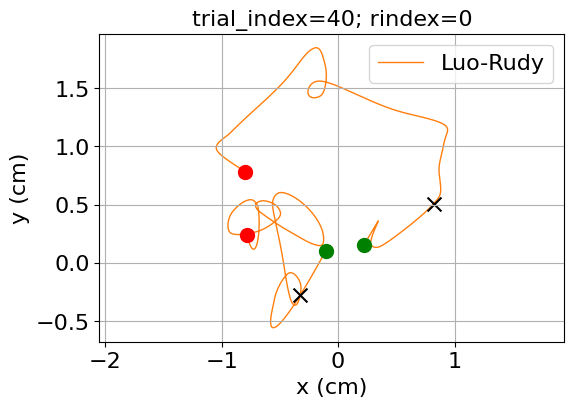

-n 


0

In [42]:

# for trial_index in range(0,max_num_trials):
if True:
    #########################################################
    # model
    #########################################################
    trajdir = os.path.join(fldr,trial_fldr_lst[trial_index])
    df = pd.read_csv(trajdir)
    df['cid'] = df['particle']
    DT = np.around(df['t'].drop_duplicates().sort_values().diff().dropna().median(),7)/1e3 #s
    num_frames_trgt = np.floor(lifetime_trgt/DT)
    dlifeframes = df.groupby(by='particle')['frame'].count().copy()

    #filter shorter lived tips
    df_tips = pd.DataFrame(dlifeframes[dlifeframes>=num_frames_trgt].sort_values())

    #find creation and annihilation partners for each tip
    cid_set_recombining = set()
    dict_recombining_lst = []
    for cid,row in df_tips.iterrows():
        if not (cid in cid_set_recombining):
            #determine birth/death partners, as before
            cid_birthmate, nearest_dist_birth, t_birth = identify_birth_partner(df,cid,distance_L2_pbc,cid_others=None)
            cid_deathmate, nearest_dist_death, t_death = identify_death_partner(df,cid,distance_L2_pbc,cid_others=None)
            #record any recombination
            if cid_birthmate==cid_deathmate:
                cid_set_recombining.update({cid})
                cid_set_recombining.update({cid_birthmate})
                dict_recombining_lst.append(dict(
                    cid_self = cid,
                    cid_other = cid_birthmate,
                    nearest_dist_birth = nearest_dist_birth*ds, #cm
                    nearest_dist_death = nearest_dist_death*ds, #cm
                    t_birth = t_birth, #ms
                    t_death = t_death, #ms
                    lifetime = (t_death - t_birth)/1e3, #s
                ))
    df_recombining = pd.DataFrame(dict_recombining_lst); del dict_recombining_lst
    num_recombinations = df_recombining.shape[0]
#     for rindex in range(num_recombinations):
    if True:
        #select a recombination event
        row = df_recombining.loc[rindex]

        #get raw trajectories for the selected recombination
        xy_values_self_raw = df[df['cid']==row['cid_self']].sort_values(by='t')[['x','y']].values
        xy_values_other_raw = df[df['cid']==row['cid_other']].sort_values(by='t')[['x','y']].values

        #trajectories share the same shape. consider valid recombination event
        if xy_values_self_raw.shape==xy_values_other_raw.shape:
            #unwrap_xy_values
            xy_values_self_unwrapped = np.stack(unwrap_xy_values(xy_values_self_raw[:,0],xy_values_self_raw[:,1],
                                                    width,height,jump_thresh=None,)).T
            xy_values_other_unwrapped = np.stack(unwrap_xy_values(xy_values_other_raw[:,0],xy_values_other_raw[:,1],
                                                    width,height,jump_thresh=None,)).T
            point1 = xy_values_self_unwrapped[0]
            point2 = xy_values_other_unwrapped[0]
            #undo any relative winding between initial positions
            dw_lst = []
            for q1, q2, wid in zip(point1, point2, mesh_shape):
                iw = np.argmin(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
                dw = np.array([0.,wid,-wid])[iw]
                dw_lst.append(dw)

            #unwind and center about birth
            xy_values_other_unwrapped_unwinding = xy_values_other_unwrapped + np.array(dw_lst)
            xy_center = np.mean((point1,xy_values_other_unwrapped_unwinding[0]),axis=0)

            #center and scale to centimeters
            xy_values_self_full = ds*(xy_values_self_unwrapped - xy_center)
            xy_values_other_full = ds*(xy_values_other_unwrapped_unwinding - xy_center)

            #upsample
            dt = 1e-5
            t_values = np.arange(row['t_birth']/1e3,(row['t_death']+DT)/1e3,DT)
            t_values_interp = np.arange(row['t_birth']/1e3,(row['t_death']+DT)/1e3,dt)
            t_values = t_values[:xy_values_self_full.shape[0]].copy() 
            xy_values_self_full = np.stack((np.interp(t_values_interp,t_values,xy_values_self_full[:,0]),
                                            np.interp(t_values_interp,t_values,xy_values_self_full[:,1]))).T
            xy_values_other_full = np.stack((np.interp(t_values_interp,t_values,xy_values_other_full[:,0]),
                                            np.interp(t_values_interp,t_values,xy_values_other_full[:,1]))).T

            #smooth
            creation_duration = 0.1 #s #both FK and LR
            window_dur = float(creation_duration)# 0.1 #s
            window_length=int(window_dur/dt)
            if window_length%2==0:
                window_length+=1 #must be odd
            xy_values_self_full = savgol_filter(xy_values_self_full.T,
                window_length=window_length,polyorder=3,
                deriv=0,delta=1.0,axis=-1,mode='interp',cval=0.0,).T
            xy_values_other_full = savgol_filter(xy_values_other_full.T,
                window_length=window_length,polyorder=3,
                deriv=0,delta=1.0,axis=-1,mode='interp',cval=0.0,).T

            #########################################################
            # viewer
            #########################################################
            #visualize like in Fig. 1B in the annihilation dynamics paper
            color = 'C1'
            fontsize=16
            lw=1
            title = f"{trial_index=}; {rindex=}"
            print(title)
            fig,ax=plt.subplots(figsize=(6,4))
            #plot birth
            # plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100)
            # plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100)
            plt.scatter([xy_values_self_full[0,0]],[xy_values_self_full[0,1]],color='green',s=100)
            plt.scatter([xy_values_other_full[0,0]],[xy_values_other_full[0,1]],color='green',s=100)
            try:
                #plot repulsion turning off
                ioff = int(creation_duration/dt)
            #     plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x')
            #     plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x')
                plt.scatter([xy_values_self_full[ioff,0]],[xy_values_self_full[ioff,1]],color='k',s=100,marker='x')
                plt.scatter([xy_values_other_full[ioff,0]],[xy_values_other_full[ioff,1]],color='k',s=100,marker='x')
            except IndexError as e:
                pass
            #plot death
            # plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100)
            # plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100)
            plt.scatter([xy_values_self_full[-1,0]],[xy_values_self_full[-1,1]],color='red',s=100)
            plt.scatter([xy_values_other_full[-1,0]],[xy_values_other_full[-1,1]],color='red',s=100)

            #plot trajectories
            # plt.plot(xy_values_self[:,0],xy_values_self[:,1],color='gray',lw=lw,zorder=-1)
            # plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=lw,zorder=-1,label='LPM Fit to\nFenton-Karma')
            plt.plot(xy_values_self_full[:,0],xy_values_self_full[:,1],color=color,lw=lw,zorder=-1)
            plt.plot(xy_values_other_full[:,0],xy_values_other_full[:,1],color=color,lw=lw,zorder=-1,label='Luo-Rudy')
            # format_plot
            format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
            ax = plt.gca()
            ax.grid('on')
            ax.axis('equal')
            ax.legend(fontsize=fontsize)
            ax.set_title(title,fontsize=fontsize)
            plt.show()
beep(1)



## simulate LPM fit

In [43]:
#recall LPM movement parameters for the FK model
# D = 0.115 #cm^2/s FK
D = 0.42 #cm^2/s LR
# a = 1.552 #cm^2/s FK
a = 9.3 #cm^2/s LR
# r = 0.457 #cm FK
r = 0.314 #cm LR
# kappa = 15 #Hz FK
kappa = 75 #Hz LR

#recall LPM creation parameters for the FK model
# Rc = 0.85 # cm FK
Rc = 1.25 # cm LR
creation_duration = 0.1 #s #both FK and LR
# b = 3.01 #±0.05 cm^2/s FK
b = 10.0 #±0.5 cm^2/s LR
# r0 = 1.31 #±0.001 cm FK
r0 = 0.202 #±0.003 cm LR

In [44]:
#place 2 particles at a given initial angle (theta0=-pi/4) centered about the origin
# theta0=-np.pi/4
theta0=+np.pi/4
rc = Rc/2.
xy0_self = rc*np.array([np.cos(theta0),np.sin(theta0)])
xy0_other = rc*np.array([np.cos(theta0+np.pi),np.sin(theta0+np.pi)])

In [45]:
dt = 1e-5
# seed = 42
seed = 5 #beautiful++
# # seed = 8 #beautiful+
# # seed = 12 #gorgeous
# # seed=13 #beautiful++
#heretim
# tmax = 30. #seconds
# tmax = 3. #seconds
tmax = .3 #seconds
printing=True
np.random.seed(seed)
rsq = r**2
t = 0
xy_lst_self = [xy0_self]
xy_lst_other = [xy0_other]
#time evolve their trajectories with no other creations/particles
nsteps = int(tmax/dt)
step = 0
while t<tmax:
    step +=1
    t+=dt
    #recall positions
    xy_self = xy_lst_self[-1]
    xy_other = xy_lst_other[-1]
    Rsq = np.sum((xy_self - xy_other) ** 2)
    x_self_next = xy_self[0]
    x_other_next = xy_other[0]
    y_self_next = xy_self[1]
    y_other_next = xy_other[1]
    dx = x_other_next - x_self_next
    dy = y_other_next - y_self_next
#     #apply repulsive force
#     if t<creation_duration:
#         x_self_next+=dt*b*dx/Rsq
#         x_other_next-=dt*b*dx/Rsq
#         y_self_next+=dt*b*dy/Rsq
#         y_other_next-=dt*b*dy/Rsq
    #apply repulsive force
    if t<creation_duration:
        x_self_next-=dt*b*dx/Rsq
        x_other_next+=dt*b*dx/Rsq
        y_self_next-=dt*b*dy/Rsq
        y_other_next+=dt*b*dy/Rsq
#     #apply attractive force
#     x_self_next-=dt*a*dx/Rsq
#     x_other_next+=dt*a*dx/Rsq
#     y_self_next-=dt*a*dy/Rsq
#     y_other_next+=dt*a*dy/Rsq
    #apply attractive force
    x_self_next+=dt*a*dx/Rsq
    x_other_next-=dt*a*dx/Rsq
    y_self_next+=dt*a*dy/Rsq
    y_other_next-=dt*a*dy/Rsq
    #apply noise
    Dcoeff = np.sqrt(2.*D*dt)
    x_self_next += Dcoeff*np.random.normal()
    x_other_next+= Dcoeff*np.random.normal()
    y_self_next+=  Dcoeff*np.random.normal()
    y_other_next+= Dcoeff*np.random.normal()
    #record
    xy_self = np.array([x_self_next,y_self_next])
    xy_other = np.array([x_other_next,y_other_next])
    xy_lst_self.append(xy_self)
    xy_lst_other.append(xy_other)
    if printing and (step % 1000 == 0):
        printProgressBar(step,nsteps)    
    #implement capture stop condition
    if Rsq<rsq:
        p = np.random.rand()
        if p<kappa*dt:
            tmax = t
print(f"\n{tmax=}")

 |████████████████████████████████████████████████████████████████████████████------------------------| 76.7% 
tmax=0.23944000000009869


In [46]:
xy_values_self = np.stack(xy_lst_self)
xy_values_other = np.stack(xy_lst_other)

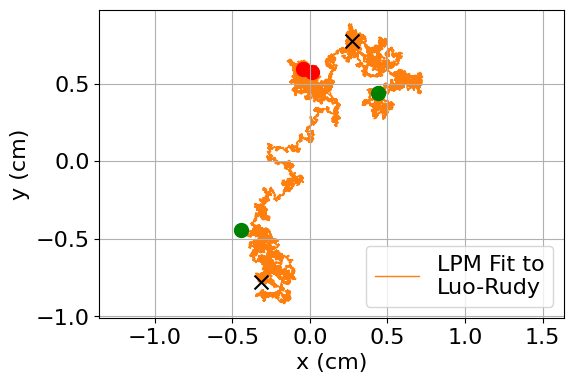

In [47]:
#TODO: visualize like in Fig. 1B in the annihilation dynamics paper
color = 'C1'
fontsize=16
lw=1
fig,ax=plt.subplots(figsize=(6,4))
#plot birth
plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100)
plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100)
try:
    #plot repulsion turning off
    ioff = int(creation_duration/dt)
    plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x')
    plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x')
except IndexError as e:
    pass
#plot death
plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100)
plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100)


plt.plot(xy_values_self[:,0],xy_values_self[:,1],color=color,lw=lw,zorder=-1)
plt.plot(xy_values_other[:,0],xy_values_other[:,1],color=color,lw=lw,zorder=-1,label='LPM Fit to\nLuo-Rudy')
# plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=2)

format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
ax = plt.gca()
ax.grid('on')
ax.axis('equal')
ax.legend(fontsize=fontsize)
plt.show()

trial_index=40; rindex=0


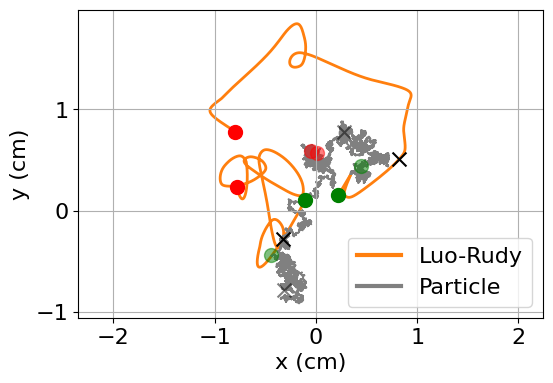

In [48]:
#########################################################
# viewer
#########################################################
#visualize like in Fig. 1B in the annihilation dynamics paper
color = 'C1'
fontsize=16
lw=1
alpha=0.5
title = f"{trial_index=}; {rindex=}"
print(title)
fig,ax=plt.subplots(figsize=(6,4))
#plot birth
plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100,alpha=alpha)
plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100,alpha=alpha)
plt.scatter([xy_values_self_full[0,0]],[xy_values_self_full[0,1]],color='green',s=100)
plt.scatter([xy_values_other_full[0,0]],[xy_values_other_full[0,1]],color='green',s=100)
try:
    #plot repulsion turning off
    ioff = int(creation_duration/dt)
    plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x',alpha=alpha)
    plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x',alpha=alpha)
    plt.scatter([xy_values_self_full[ioff,0]],[xy_values_self_full[ioff,1]],color='k',s=100,marker='x')
    plt.scatter([xy_values_other_full[ioff,0]],[xy_values_other_full[ioff,1]],color='k',s=100,marker='x')
except IndexError as e:
    pass
#plot death
plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100,alpha=alpha)
plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100,alpha=alpha)
plt.scatter([xy_values_self_full[-1,0]],[xy_values_self_full[-1,1]],color='red',s=100)
plt.scatter([xy_values_other_full[-1,0]],[xy_values_other_full[-1,1]],color='red',s=100)

#plot trajectories
plt.plot(xy_values_self_full[:,0],xy_values_self_full[:,1],color=color,lw=lw+1,zorder=-1)
plt.plot(xy_values_other_full[:,0],xy_values_other_full[:,1],color=color,lw=lw+1,zorder=-1,label='Luo-Rudy')
plt.plot(xy_values_self[:,0],xy_values_self[:,1],color='gray',lw=lw,zorder=-1)
plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=lw,zorder=-1,label='Particle')
# format_plot
format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
ax = plt.gca()
ax.grid('on')
ax.axis('equal')
legend = ax.legend(fontsize=fontsize)
#increase the line width in the legend
for line in legend.get_lines():
    line.set_linewidth(3)
# ax.set_title(title,fontsize=fontsize)
plt.show()

trial_index=40; rindex=0


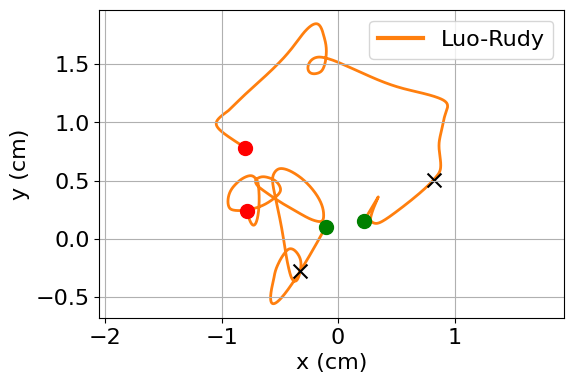

In [49]:
#########################################################
# viewer
#########################################################
#visualize like in Fig. 1B in the annihilation dynamics paper
color = 'C1'
fontsize=16
lw=1
alpha=0.5
title = f"{trial_index=}; {rindex=}"
print(title)
fig,ax=plt.subplots(figsize=(6,4))
#plot birth
# plt.scatter([xy_values_self[0,0]],[xy_values_self[0,1]],color='green',s=100,alpha=alpha)
# plt.scatter([xy_values_other[0,0]],[xy_values_other[0,1]],color='green',s=100,alpha=alpha)
plt.scatter([xy_values_self_full[0,0]],[xy_values_self_full[0,1]],color='green',s=100)
plt.scatter([xy_values_other_full[0,0]],[xy_values_other_full[0,1]],color='green',s=100)
try:
    #plot repulsion turning off
    ioff = int(creation_duration/dt)
#     plt.scatter([xy_values_self[ioff,0]],[xy_values_self[ioff,1]],color='k',s=100,marker='x',alpha=alpha)
#     plt.scatter([xy_values_other[ioff,0]],[xy_values_other[ioff,1]],color='k',s=100,marker='x',alpha=alpha)
    plt.scatter([xy_values_self_full[ioff,0]],[xy_values_self_full[ioff,1]],color='k',s=100,marker='x')
    plt.scatter([xy_values_other_full[ioff,0]],[xy_values_other_full[ioff,1]],color='k',s=100,marker='x')
except IndexError as e:
    pass
#plot death
# plt.scatter([xy_values_self[-1,0]],[xy_values_self[-1,1]],color='red',s=100,alpha=alpha)
# plt.scatter([xy_values_other[-1,0]],[xy_values_other[-1,1]],color='red',s=100,alpha=alpha)
plt.scatter([xy_values_self_full[-1,0]],[xy_values_self_full[-1,1]],color='red',s=100)
plt.scatter([xy_values_other_full[-1,0]],[xy_values_other_full[-1,1]],color='red',s=100)

#plot trajectories
plt.plot(xy_values_self_full[:,0],xy_values_self_full[:,1],color=color,lw=lw+1,zorder=-1)
plt.plot(xy_values_other_full[:,0],xy_values_other_full[:,1],color=color,lw=lw+1,zorder=-1,label='Luo-Rudy')
# plt.plot(xy_values_self[:,0],xy_values_self[:,1],color='gray',lw=lw,zorder=-1)
# plt.plot(xy_values_other[:,0],xy_values_other[:,1],color='gray',lw=lw,zorder=-1,label='Particle')
# format_plot
format_plot(fontsize=fontsize,xlabel='x (cm)',ylabel='y (cm)')
ax = plt.gca()
ax.grid('on')
ax.axis('equal')
legend = ax.legend(fontsize=fontsize)
#increase the line width in the legend
for line in legend.get_lines():
    line.set_linewidth(3)
# ax.set_title(title,fontsize=fontsize)
plt.show()